Topic - BERTopic Modelling Only Financial Text

#### **1. Research Background**

- This study aims to apply the **BERTopic** model to financial texts (such as tweets) for topic modelling, and to explore the relationship between topics and market performance by combining sentiment analysis and market data.
    
- The goal is to test whether the sentiment of different topics can serve as trading signals and thereby build effective trading strategies.
    

---

#### **2. Data and Methodology**

##### **Data Sources**

1. **Financial Tweet Data**:
    
    - Includes tweet texts and their sentiment scores from 2019 to 2022.
        
    - After preprocessing (e.g., removing empty tweets and time filtering), valid data was retained.
        
2. **Market Data**:
    
    - Includes technical indicators of Nvidia (NVDA), such as opening price, closing price, and trading volume.
        
    - Contains the VIX index as a market volatility factor.
        

##### **Methodology**

1. **BERTopic Model**:
    
    - Uses `SentenceTransformer` to extract text embeddings.
        
    - Applies `HDBSCAN` clustering to generate topics.
        
    - Outputs the dominant daily topic and its sentiment score.
        
2. **Sentiment and Topic Analysis**:
    
    - Calculates the average sentiment score of each daily topic.
        
    - Classifies topics into sentiment categories based on a keyword lexicon (e.g., bullish and bearish vocabularies).
        
3. **Trading Strategy**:
    
    - Generates trading signals based on topic sentiment:
        
        - use grid search to find the optimal performance
            
    - Compares the performance of topic-based strategies with the market benchmark (Buy & Hold).

## BERTopic modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import warnings
import os
from tqdm import tqdm
from hdbscan import HDBSCAN
warnings.filterwarnings('ignore')

SAMPLE!!!-->too much data for CPU to handle with in HDBSCAN step...almost 1GB and 500000+ data!

In [2]:
import os
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from bertopic import BERTopic

# avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# read data
df = pd.read_csv("../2_data/financial_tweets_with_sentiment.csv", parse_dates=["Date"])
df = df.dropna(subset=['Processed_Tweet'])  
df = df[(df["Date"] >= "2019-01-01") & (df["Date"] <= "2022-12-31")].copy()
df["YearMonth"] = df["Date"].dt.to_period("M")

texts = df["Processed_Tweet"].astype(str).tolist()

texts = df["Processed_Tweet"].astype(str).tolist()
texts = list(tqdm(texts, desc="Preparing texts"))

# Step 2: Load embedded model IF YOU DON'T HAVE GPU, DROP 'DEVICE=CUDA'
embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Step 3: Define BERTopic 
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=5, metric='euclidean')
topic_model = BERTopic(
    embedding_model=embedding_model,
    language="english",
    calculate_probabilities=False, # initially not produce prob (too slow)
    verbose=True,
    nr_topics = 30
)

# Step 4: model training
topics, _ = topic_model.fit_transform(texts)
df["topic"] = topics

# check the number of topics
n_noise = (df["topic"] == -1).sum()
print(f"❗ Number of tweets that could not be categorized: {n_noise} ({n_noise / len(df):.2%})")

# filter out noise
df = df[df["topic"] != -1].reset_index(drop=True)

# store the topic model
df.to_csv("../2_data/with_BERTtopics.csv", index=False)


Preparing texts: 100%|██████████| 40557/40557 [00:00<00:00, 9807909.79it/s]
2025-05-24 14:04:22,473 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1268 [00:00<?, ?it/s]

2025-05-24 14:04:56,328 - BERTopic - Embedding - Completed ✓
2025-05-24 14:04:56,329 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-24 14:05:11,656 - BERTopic - Dimensionality - Completed ✓
2025-05-24 14:05:11,657 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-24 14:05:14,364 - BERTopic - Cluster - Completed ✓
2025-05-24 14:05:14,364 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-24 14:05:14,669 - BERTopic - Representation - Completed ✓
2025-05-24 14:05:14,670 - BERTopic - Topic reduction - Reducing number of topics
2025-05-24 14:05:14,684 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-24 14:05:14,856 - BERTopic - Representation - Completed ✓
2025-05-24 14:05:14,858 - BERTopic - Topic reduction - Reduced number of topics from 398 to 30


❗ Number of tweets that could not be categorized: 19941 (49.17%)


In [3]:
# Step 6: Results Evaluation
import matplotlib.pyplot as plt


# 1. check the topic overview
print(topic_model.get_topic_info().head(10))     # top 10 topic 
print(topic_model.get_topic(0))                  # check topic 0
# 2. check the topic distribution
fig_hierarchy = topic_model.visualize_hierarchy()
fig_hierarchy.show()

# 3. Visualize topic distribution 
fig_barchart = topic_model.visualize_barchart(top_n_topics=10)
fig_barchart.show()

fig_topics = topic_model.visualize_topics()
fig_topics.show()


topic_counts = df["topic"].value_counts()
print(topic_counts.head(10))

# 4. Visualize topics over time
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
df_clean = df.dropna(subset=["Date", "Processed_Tweet", "topic"])
docs = df_clean["Processed_Tweet"].tolist()
timestamps = df_clean["Date"].tolist()
topics = df_clean["topic"].tolist()
topics_over_time = topic_model.topics_over_time(docs, timestamps, topics=topics)
fig = topic_model.visualize_topics_over_time(topics_over_time)
fig.show()

# 5. print top 5 topics
print("\nTop 5 Topics:")
for topic_num in range(5):
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))


# 6. print top 5 topics with their keywords
topic_keywords = {}
for topic_num in df["topic"].unique():
    words = topic_model.get_topic(topic_num)
    keywords = [word for word, _ in words[:10]]
    topic_keywords[topic_num] = keywords

# 7. Manual setup of bullish / bearish keyword library (extensible)
bullish_words = {"growth", "beat", "record", "strong", "buy", "profit", "boom", "innovation", "optimism"}
bearish_words = {"loss", "fear", "fall", "crash", "bad", "bear", "cut", "warning", "down", "panic"}

# Determine the number of positive/negative sentiment words in each topic keyword
bullish_topics = []
bearish_topics = []

for topic_num, keywords in topic_keywords.items():
    score = sum(kw in bullish_words for kw in keywords) - sum(kw in bearish_words for kw in keywords)
    if score >= 1:
        bullish_topics.append(topic_num)
    elif score <= -1:
        bearish_topics.append(topic_num)

print("🐂 Bullish Topics:", bullish_topics)
print("🐻 Bearish Topics:", bearish_topics)




   Topic  Count                             Name  \
0     -1  19941            -1_nvda_stock_amd_buy   
1      0  13206         0_nvda_stock_share_split   
2      1   2552        1_trade_stock_market_nvda   
3      2   2210     2_bullish_green_nvda_bearish   
4      3   1173      3_elliottwav_updat_box_blue   
5      4    339  4_sentiment_paid_strike_premium   
6      5    110           5_time_trade_close_day   
7      6    103    6_star_freedom_watchlist_roku   
8      7     87           7_put_option_lynk_bayo   
9      8     83        8_scan_track_gainer_loser   

                                      Representation  \
0  [nvda, stock, amd, buy, market, go, share, pri...   
1  [nvda, stock, share, split, min, last, price, ...   
2  [trade, stock, market, nvda, day, like, amd, s...   
3  [bullish, green, nvda, bearish, flow, top, cha...   
4  [elliottwav, updat, box, blue, view, area, pla...   
5  [sentiment, paid, strike, premium, call, bulli...   
6  [time, trade, close, day, coinfl

2025-05-24 14:05:17,394 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 1096) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 


topic
0    13206
1     2552
2     2210
3     1173
4      339
5      110
6      103
7       87
8       83
9       82
Name: count, dtype: int64


1096it [00:15, 71.93it/s]



Top 5 Topics:

Topic 0:
[('nvda', np.float64(0.04064991725869733)), ('stock', np.float64(0.032447948736335)), ('share', np.float64(0.029741519480513866)), ('split', np.float64(0.02264642584892377)), ('min', np.float64(0.020712839021477688)), ('last', np.float64(0.01999081402372119)), ('price', np.float64(0.017578811761796095)), ('nvidia', np.float64(0.01626775465130065)), ('move', np.float64(0.01618730982623291)), ('target', np.float64(0.016145526675843364))]

Topic 1:
[('trade', np.float64(0.01949056741031948)), ('stock', np.float64(0.01607299336312297)), ('market', np.float64(0.01578219480332602)), ('nvda', np.float64(0.013546797820766787)), ('day', np.float64(0.013202241831364848)), ('like', np.float64(0.012148146643196437)), ('amd', np.float64(0.012123324977872017)), ('spi', np.float64(0.01183670559488808)), ('watch', np.float64(0.01147663356078633)), ('break', np.float64(0.011220339759126029))]

Topic 2:
[('bullish', np.float64(0.15735486920016473)), ('green', np.float64(0.060152

# Trading Strategy

Topic 0: Best thresholds => positive: 0.01, negative: -0.09 ; Cumulative Return: 98.48%
Topic 1: Best thresholds => positive: 0.10, negative: -0.10 ; Cumulative Return: 42.82%
Topic 2: Best thresholds => positive: 0.01, negative: -0.10 ; Cumulative Return: 54.84%
Topic 3: Best thresholds => positive: 0.06, negative: -0.09 ; Cumulative Return: 60.95%
Topic 4: Best thresholds => positive: 0.01, negative: -0.01 ; Cumulative Return: -7.31%
Topic 5: Best thresholds => positive: 0.01, negative: -0.01 ; Cumulative Return: 17.82%
Topic 6: Best thresholds => positive: 0.01, negative: -0.01 ; Cumulative Return: -6.87%
Topic 7: Best thresholds => positive: 0.01, negative: -0.01 ; Cumulative Return: -1.42%
Topic 8: Best thresholds => positive: 0.01, negative: -0.01 ; Cumulative Return: -24.57%
Topic 9: Best thresholds => positive: 0.01, negative: -0.01 ; Cumulative Return: 13.40%
Topic 10: Best thresholds => positive: 0.01, negative: -0.01 ; Cumulative Return: 0.44%
Topic 11: Best thresholds => po

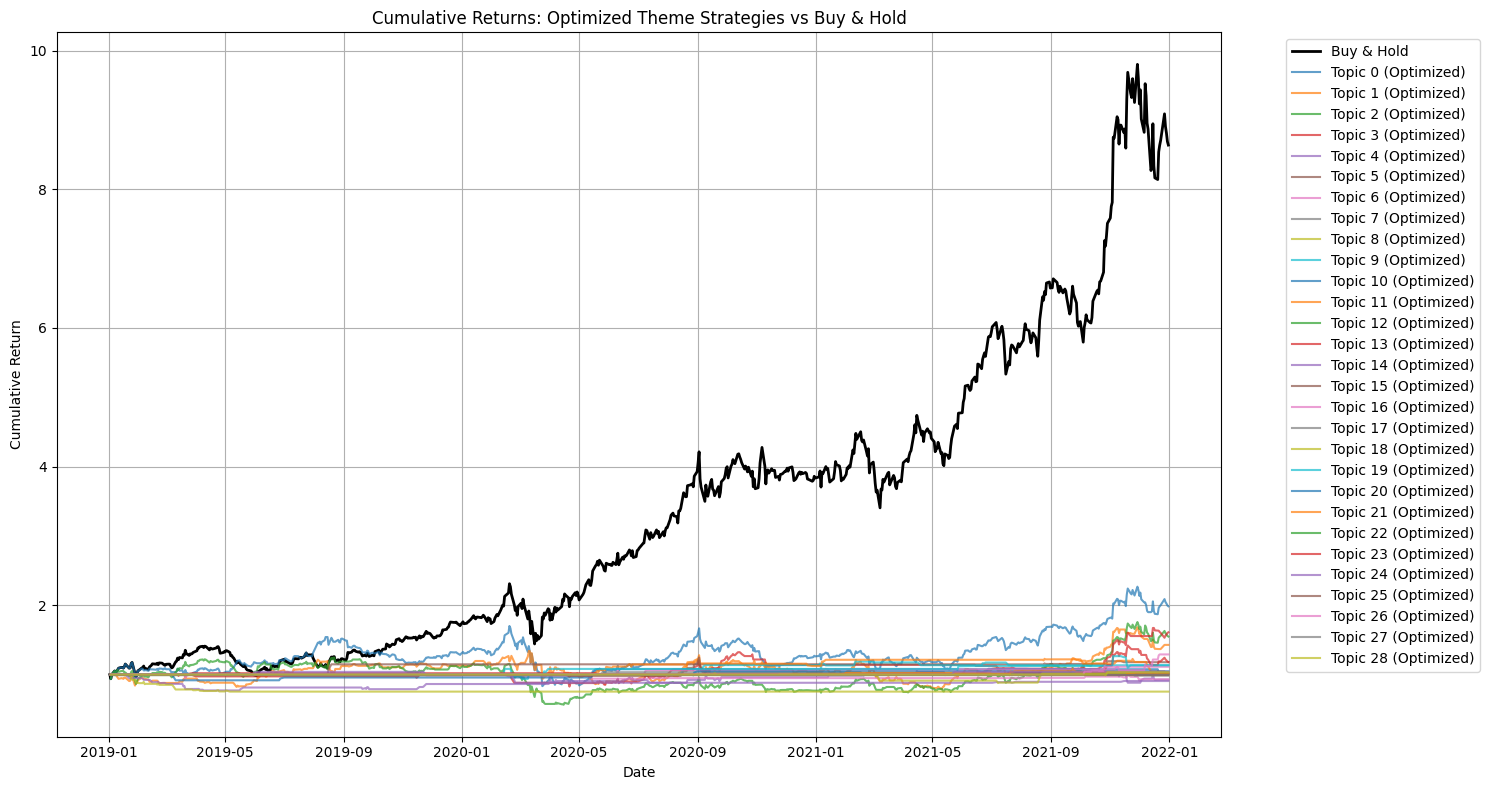


Final Returns by Optimized Thematic Strategy:
Topic 0 (Optimized): 98.48%
Topic 1 (Optimized): 42.82%
Topic 2 (Optimized): 54.84%
Topic 3 (Optimized): 60.95%
Topic 4 (Optimized): -7.31%
Topic 5 (Optimized): 17.82%
Topic 6 (Optimized): -6.87%
Topic 7 (Optimized): -1.42%
Topic 8 (Optimized): -24.57%
Topic 9 (Optimized): 13.40%
Topic 10 (Optimized): 0.44%
Topic 11 (Optimized): -0.00%
Topic 12 (Optimized): 0.00%
Topic 13 (Optimized): 18.19%
Topic 14 (Optimized): -9.33%
Topic 15 (Optimized): 1.84%
Topic 16 (Optimized): 11.24%
Topic 17 (Optimized): 0.69%
Topic 18 (Optimized): 3.22%
Topic 19 (Optimized): 13.38%
Topic 20 (Optimized): 4.71%
Topic 21 (Optimized): 2.77%
Topic 22 (Optimized): 0.00%
Topic 23 (Optimized): 0.00%
Topic 24 (Optimized): 4.14%
Topic 25 (Optimized): 0.00%
Topic 26 (Optimized): 29.07%
Topic 27 (Optimized): 0.00%
Topic 28 (Optimized): 3.44%
Buy & Hold: 763.63%


Exception ignored in: <function ResourceTracker.__del__ at 0x1042e11c0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107a011c0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/m

In [ ]:
import pandas as pd
import numpy as np

# read the sentiment and price data
price_df = pd.read_csv('../2_data/sentiment_price_vix_inner_aligned.csv')
price_df['Date'] = pd.to_datetime(price_df['index'])
price_df = price_df.set_index('Date')

# read the sentiment data with topics
df['Date'] = pd.to_datetime(df['Date'])
daily_theme_sentiment = df.groupby(['Date', 'topic'])['sentiment_score'].mean().unstack()


# 2. Grid Search for Optimal Thresholds
positive_thresholds = np.arange(0.01, 0.11, 0.01)
negative_thresholds = -np.arange(0.01, 0.11, 0.01)

# store the best thresholds and returns for each topic
best_thresholds_by_topic = {}

# for each topic, perform grid search to find the best positive and negative thresholds
for topic in daily_theme_sentiment.columns:
    best_return = -np.inf
    best_thresh = (None, None)
    
    # use grid search to find the best combination of positive and negative thresholds
    for pos_thresh in positive_thresholds:
        for neg_thresh in negative_thresholds:
            # calculate the rolling mean sentiment signal for the topic
            signal = daily_theme_sentiment[topic].rolling(3, min_periods=1).mean()
            # generate the position based on the thresholds
            position = (signal > pos_thresh).astype(int) - (signal < neg_thresh).astype(int)
            
            # Construct strategy data and align price data
            strategy_data = pd.DataFrame({'position': position})
            strategy_data = strategy_data.merge(price_df[['nvda_close']], left_index=True, right_index=True, how='inner')
            
            # Calculating Daily Returns on Stocks
            returns = price_df['nvda_close'].pct_change().fillna(0)
            # calculate cumulative returns for the strategy
            strategy_returns = strategy_data['position'].shift(1) * returns.loc[strategy_data.index]
            cum_return = (1 + strategy_returns).prod() - 1
            
            # Update the optimal threshold combination for this topic
            if cum_return > best_return:
                best_return = cum_return
                best_thresh = (pos_thresh, neg_thresh)
    
    best_thresholds_by_topic[topic] = (best_thresh, best_return)
    print(f"Topic {topic}: Best thresholds => positive: {best_thresh[0]:.2f}, negative: {best_thresh[1]:.2f} ; Cumulative Return: {best_return:.2%}")


# 3. calculate cumulative returns for each strategy and plot them
returns = price_df['nvda_close'].pct_change().fillna(0)

plt.figure(figsize=(15, 8))

# Start by plotting the payoff curve of the “buy and hold” strategy
cum_returns_buy_and_hold = (1 + returns).cumprod()
plt.plot(cum_returns_buy_and_hold.index, cum_returns_buy_and_hold, label='Buy & Hold', color='black', linewidth=2)

# Plot the strategy payoff curve for each theme using the optimal threshold portfolio
print("\nCumulative Returns for Optimized Strategies:")
for topic, (best_thresh, best_return) in best_thresholds_by_topic.items():
    pos_thresh, neg_thresh = best_thresh

    # Re-generate the signal using the optimal threshold
    signal = daily_theme_sentiment[topic].rolling(3, min_periods=1).mean()
    position = (signal > pos_thresh).astype(int) - (signal < neg_thresh).astype(int)

    # data alignment
    strategy_data = pd.DataFrame({'position': position})
    strategy_data = pd.merge(
        strategy_data,
        price_df[['nvda_close']],
        left_index=True,
        right_index=True,
        how='inner'
    )

    # calculate cumulative returns for the strategy
    # make sure to shift the position to avoid lookahead bias
    strategy_returns = strategy_data['position'].shift(1) * returns.loc[strategy_data.index]
    cum_strategy_returns = (1 + strategy_returns).cumprod()

    # plot
    plt.plot(cum_strategy_returns.index, cum_strategy_returns, label=f'Topic {topic} (Optimized)', alpha=0.7)

plt.title('Cumulative Returns: Optimized Theme Strategies vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the final payoff for each optimal strategy
print("\nFinal Returns by Optimized Thematic Strategy:")
for topic, (best_thresh, best_return) in best_thresholds_by_topic.items():

    print(f"Topic {topic} (Optimized): {best_return:.2%}")

print(f"Buy & Hold: {cum_returns_buy_and_hold.iloc[-1]-1:.2%}")